# Lending Club Default Rate Analysis

In [2]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import RFE

from sklearn.svm import SVR
from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVR

import seaborn as sns
import matplotlib.pylab as pl
%matplotlib inline

### Columns Interested
**loan_status** -- Current status of the loan<br/>

loan_amnt -- The listed amount of the loan applied for by the borrower. If at some point in time, the credit        department reduces the loan amount, then it will be reflected in this value.<br/>
int_rate -- interest rate of the loan <br/>
sub_grade -- LC assigned sub loan grade -- **dummie**  (grade -- LC assigned loan grade<br/>-- **dummie**)<br/> 

purpose -- A category provided by the borrower for the loan request. -- **dummie**<br/> 

annual_inc -- The self-reported annual income provided by the borrower during registration.<br/>
emp_length -- Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. -- **dummie**<br/> 

fico_range_low<br/>
fico_range_high

home_ownership -- The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER -- **dummie**<br/>
tot_cur_bal -- Total current balance of all accounts							
num_actv_bc_tl -- number of active bank accounts   (*avg_cur_bal -- average current balance of all accounts *)<br/>

mort_acc -- number of mortgage accounts<br/>

num_actv_rev_tl	-- Number of currently active revolving trades<br/>
dti	-- A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.																								
pub_rec_bankruptcies - Number of public record bankruptcies<br/>


## 2015 Lending Club Data
### 1. Approved Loans

In [3]:
df_app_2015 = pd.read_csv('LoanStats3d_securev1.csv.zip', compression='zip',header=1, skiprows=[-2,-1],low_memory=False)

In [4]:
df_app_2015.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68615169,NaN,16000.0,16000.0,16000.0,60 months,8.49%,328.19,B,B1,...,0.0,3.0,87.5,50.0,0.0,0.0,307343.0,64371.0,23500.0,59526.0
1,68537564,NaN,8000.0,8000.0,8000.0,36 months,10.78%,261.08,B,B4,...,0.0,4.0,97.1,100.0,0.0,0.0,168819.0,148154.0,5800.0,136996.0
2,68536799,NaN,10000.0,10000.0,10000.0,36 months,10.78%,326.35,B,B4,...,0.0,2.0,100.0,33.3,0.0,0.0,190694.0,40681.0,13900.0,29512.0


In [5]:
# Pre-select columns
df = df_app_2015.ix[:, ['loan_status','loan_amnt', 'int_rate', 'sub_grade',\
                        'purpose',\
                        'annual_inc', 'emp_length', 'home_ownership',\
                        'fico_range_low','fico_range_high',\
                        'num_actv_bc_tl', 'tot_cur_bal', 'mort_acc','num_actv_rev_tl',\
                        'pub_rec_bankruptcies','dti' ]]

# 1. Data Understanding -- Selected Decriptive Analysis 

In [6]:
## in Nehal and Kay's notebooks

# 2. Data Munging
### Functions that performs data mining tasks

## 1a. Create column “default” using “loan_status” 
**Valentin**  (edited by Kay)

In [7]:
df_app_2015.tail(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421094,36271262,NaN,20000.0,20000.0,20000.0,36 months,11.99%,664.2,B,B5,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,Total amount funded in policy code 1: 6417608175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,Total amount funded in policy code 2: 1944088810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df.head(3)

,loan_status,loan_amnt,int_rate,sub_grade,purpose,annual_inc,emp_length,home_ownership,fico_range_low,fico_range_high,num_actv_bc_tl,tot_cur_bal,mort_acc,num_actv_rev_tl,pub_rec_bankruptcies,dti
0,Current,16000.0,8.49%,B1,credit_card,62000.0,5 years,MORTGAGE,720.0,724.0,4.0,227708.0,3.0,5.0,0.0,28.92
1,Current,8000.0,10.78%,B4,debt_consolidation,45000.0,< 1 year,MORTGAGE,670.0,674.0,3.0,148154.0,2.0,11.0,0.0,21.23
2,Current,10000.0,10.78%,B4,debt_consolidation,41600.0,3 years,MORTGAGE,695.0,699.0,2.0,168304.0,2.0,5.0,0.0,15.78


In [9]:
df.loan_status.unique()

array(['Current', 'Fully Paid', 'Default', 'Charged Off',
       'Late (16-30 days)', 'Late (31-120 days)', 'In Grace Period', nan], dtype=object)

In [10]:
df = df.dropna()

In [11]:
len(df)

421095

In [12]:
#df.loan_status.fillna('none', inplace=True)  ## there is no nan

In [13]:
df.loan_status.unique()

array(['Current', 'Fully Paid', 'Default', 'Charged Off',
       'Late (16-30 days)', 'Late (31-120 days)', 'In Grace Period'], dtype=object)

In [14]:
defaulters=['Default','Charged Off', 'Late (31-120 days)']
non_defaulters=['Fully Paid']
uncertain = ['Current','Late (16-30 days)','In Grace Period', 'none']

In [15]:
len(df[df.loan_status.isin(uncertain)].loan_status)

283825

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421095 entries, 0 to 421094
Data columns (total 16 columns):
loan_status             421095 non-null object
loan_amnt               421095 non-null float64
int_rate                421095 non-null object
sub_grade               421095 non-null object
purpose                 421095 non-null object
annual_inc              421095 non-null float64
emp_length              421095 non-null object
home_ownership          421095 non-null object
fico_range_low          421095 non-null float64
fico_range_high         421095 non-null float64
num_actv_bc_tl          421095 non-null float64
tot_cur_bal             421095 non-null float64
mort_acc                421095 non-null float64
num_actv_rev_tl         421095 non-null float64
pub_rec_bankruptcies    421095 non-null float64
dti                     421095 non-null float64
dtypes: float64(10), object(6)
memory usage: 54.6+ MB


In [18]:
## select instances of defaulters and non_defulters
df2 = df.copy()

df2['Target']= 2 ## uncertain
df2.loc[df2.loan_status.isin(defaulters),'Target'] = 0  ## defaulters
df2.loc[df2.loan_status.isin(non_defaulters),'Target'] = 1  ## paid -- (and to whom to issue the loan)

print('Value in Target value for non defaulters')
print(df2.loc[df2.loan_status.isin(non_defaulters)].Target.unique())
print(len(df2[df2['Target'] == 1]))

print('Value in Target value for defaulters')
print(df2.loc[df2.loan_status.isin(defaulters)].Target.unique())
print(len(df2[df2['Target'] == 0]))

print('Value in Target value for uncertained-- unlabeled ones to predict')
print(df2.loc[df2.loan_status.isin(uncertain)].Target.unique())
print(len(df2[df2['Target'] == 2]))

Value in Target value for non defaulters
[1]
94968
Value in Target value for defaulters
[0]
42302
Value in Target value for uncertained-- unlabeled ones to predict
[2]
283825


In [1]:
42302/94968

0.44543425153735994

## 2a. Convert data type  on certain columns and create dummies
**Nehal**

In [20]:
# function to create dummies
def create_dummies(column_name,df):
    temp=pd.get_dummies(df[column_name],prefix=column_name)
    df=pd.concat([df,temp],axis=1)
    return df

In [21]:
dummy_list=['emp_length','home_ownership','purpose','sub_grade']
for col in dummy_list:
    df2=create_dummies(col,df2)
for col in dummy_list:
    df2=df2.drop(col,1)

In [22]:
temp=df2['int_rate'].astype(str).str.replace('%', '').replace(' ','').astype(float)
df2=df2.drop('int_rate',1)
df2=pd.concat([df2,temp],axis=1)
df2=df2.drop('loan_status',1)

In [23]:
for col in df2.columns:
    print((df2[col].dtype))

float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
int64
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
float64


## 3a. Check and remove outliers (methods: MAD) 

In [24]:
df2.shape

(421095, 77)

In [25]:
df2['loan_amnt'][sorted(np.random.randint(0, high=10, size=5))]

0    16000.0
2    10000.0
4    10000.0
6    16800.0
6    16800.0
Name: loan_amnt, dtype: float64

In [26]:
# Reference: 
# http://stackoverflow.com/questions/22354094/pythonic-way-of-detecting-outliers-in-one-dimensional-observation-data

def main(df, col, thres):
    outliers_all = []
    ind = sorted(np.random.randint(0, high=len(df), size=5000)) # randomly pick instances from the dataframe
    #select data from our dataframe
    x = df[col][ind]
    num = len(ind)
    outliers = plot(x, col, num, thres) # append all the outliers in the list
    pl.show()
    return outliers

def mad_based_outlier(points, thresh):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def plot(x, col, num, thres):
    fig, ax = pl.subplots(nrows=1, figsize=(10, 3))
    sns.distplot(x, ax=ax, rug=True, hist=False)
    outliers = np.asarray(x[mad_based_outlier(x, thres)])
    ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    fig.suptitle('MAD-based Outlier Tests with selected {} values'.format(col, num, size=20))
    return outliers

/usr/local/lib/python3.5/dist-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


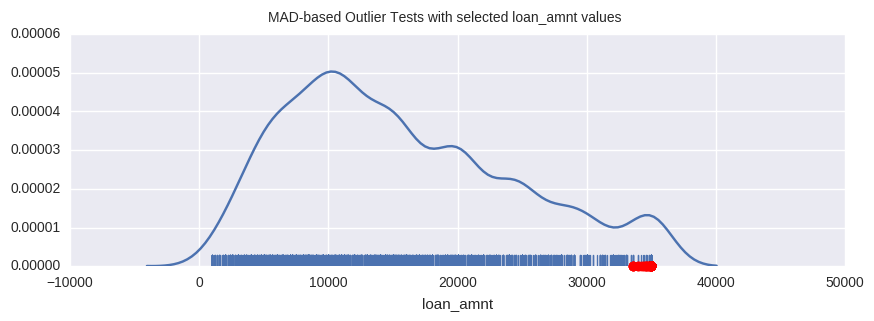

In [27]:
### Find outliers 
## 
boundries = []
outliers_loan = main(df2, 'loan_amnt', thres=2.2)

In [28]:
boundries.append(outliers_loan.min())

/usr/local/lib/python3.5/dist-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


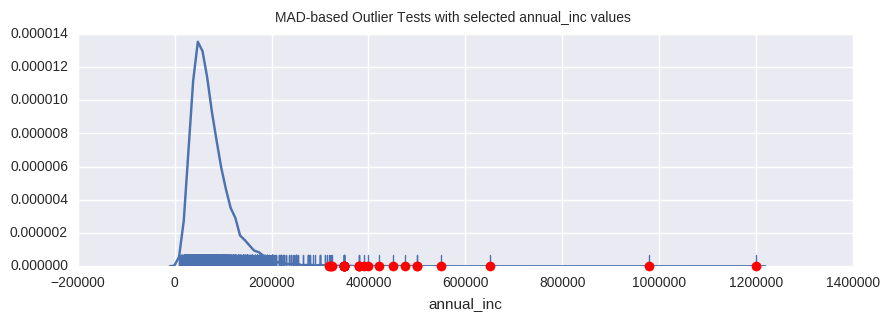

In [29]:
## annual income
outliers_inc = main(df2, 'annual_inc', 8)

In [30]:
boundries.append(outliers_inc.min())

/usr/local/lib/python3.5/dist-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


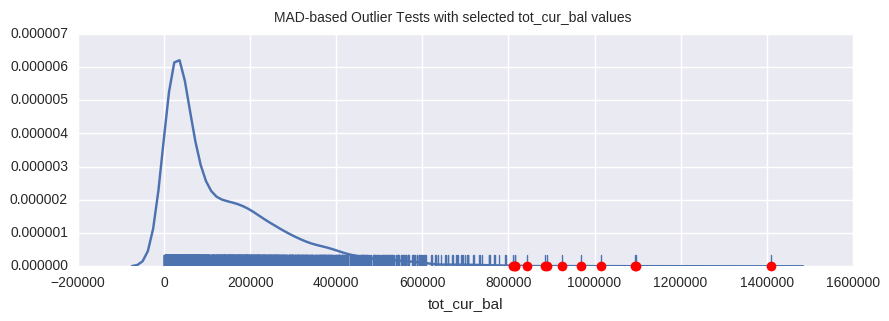

In [31]:
## For total current balance of bank accounts
outliers_bal = main(df2, 'tot_cur_bal', 8)

In [32]:
boundries.append(outliers_bal.min())

In [33]:
columns = ['loan_amnt', 'annual_inc', 'tot_cur_bal']

for col, bound in zip(columns, boundries):
    print ('Lower bound of detected Outliers for {}: {}'.format(col, bound))
    # Use the outlier boundry to "regularize" the dataframe
    df2_r = df2[df2[col] <= bound]

Lower bound of detected Outliers for loan_amnt: 33600.0
Lower bound of detected Outliers for annual_inc: 318000.0
Lower bound of detected Outliers for tot_cur_bal: 809857.0


## 4a. Remove or replace missing values of certain columns

In [106]:
# df2_r.info()

In [34]:
df2_r.shape

(419098, 77)

In [35]:
#### Fill NaN with "none"??? ####
#df_filled = df2.fillna(value='none')
#df_filled.head(3)
df2_r = df2_r.dropna()
print (len(df2_r))

419098


### 6. Save the cleaned data

In [109]:
# df2_r.to_csv('approved_loan_2015_clean.csv')